In [1]:
# import stuff

import numpy as np
import math as m
import pandas as pd
import matplotlib.pyplot as plt
import os
os.chdir('C:\\Users\\nicol\\Desktop\\pythonfiles\\micrometereology\\04')

from windrose import WindroseAxes
from scipy.optimize import minimize
from scipy.special import gamma
from scipy.integrate import quad


In [9]:
def compute_Weibull_parameters(array):
    mean = np.mean(array)
    variance = np.var(array)

    # Define a function to calculate the moments of the Weibull distribution
    def weibull_moments(params):
        k, lambd = params
        mu = lambd * gamma(1 + 1/k)
        m2 = (lambd**2 * gamma(1 + 2/k)) - mu**2
        return np.array([mu, m2])

    #Define a function to calculate the difference between observed and estimated moments
    def moment_error(params):
        observed_moments = np.array([mean, variance])
        estimated_moments = weibull_moments(params)
        return np.sum((observed_moments - estimated_moments)**2)

    # Initial guesses for k and lambd
    initial_guess = [1.0, 1.0]

    # Minimize the error function to estimate parameters
    result = minimize(moment_error, initial_guess, method='Nelder-Mead')

    # Extract estimated parameters
    estimated_k, estimated_lambda = result.x

    return(estimated_k,estimated_lambda)


def compute_Weibull(array):
    k, lam = compute_Weibull_parameters(array)

    x = np.linspace(0.01, max(array), num=len(array))
    #x = np.sort(array)
    y = k/x * (x / lam)**k * np.exp(-(x/lam)**k)

    array_name = [name for name, value in globals().items() if value is array][0]
    plt.plot(x, y)
    print(f'for {array_name}: k = {k:.2f} and lam = {lam:.2f}')


def plot_histogram(array_data, num, color, label):
    # plots the histogram of an array of data
    x = np.linspace(min(array_data), max(array_data), num=num)
    y = np.histogram(array_data, bins=num, density=True)
    delta = num/10000
    width_bar = (max(array_data) - min(array_data)) / num + delta
    #width_bar = (max(array_data) - min(array_data)) / num
    plt.bar(x, y[0], width=width_bar, align='center', color=color, label=label)
    area = np.sum(y[0]*(width_bar))
    area = np.sum(y[0]*(width_bar-delta))
    print(f"area under graph = {area:.5f}")

def plot_Weibull(array_data, k, lam, color, label):
    # computes the Weibull distribution given k and lamda and plots it in the range of the data to avoid zeros
    x = np.linspace(0.001, max(array_data), num=100)
    y = k/x * (x / lam)**k * np.exp(-(x/lam)**k)
    plt.plot(x, y, color=color, label=label)



def divide_in_sector(velocity, direction, time):
    
    indices = np.argsort(direction)[::-1]

    V_sorted = velocity[indices]
    dir_sorted = direction[indices]
    time_sorted = time[indices]

    data_sector = [[],[],[],[],[],[],[],[],[],[],[],[]]
    for j in range(1, len(data_sector)):
        for i in range(len(dir_sorted)):
            low = (j - 1) * 30 + 15
            high = (j) * 30 + 15
            if low <= dir_sorted[i] < high:
                data_sector[j].append(V_sorted[i])
    for i in range(len(dir_sorted)):
        if dir_sorted[i] < 15 or dir_sorted[i] >= 345:
            data_sector[0].append(V_sorted[i])

    return data_sector


def Weibull(U, k, A):
    y = k/U * (U/k)**k * np.exp(-(U/A)**k)
    return y

def Power1(U, Prated, Urp):
    P = Prated * (U/Urp)**3
    return P

def integrand1(U, k, A, Prated, Urp, Ucutoff):
    return Weibull(U, k, A) * Power1(U, Prated, Urp)

def integrand2(U, k, A, Prated, Urp, Ucutoff):
    return Weibull(U, k, A) * Prated

def integrate_function(func, a, b, *args):
    result, error = quad(func, a, b, args=args)
    return result



for V_array: k = 2.23 and lam = 9.29
area under graph = 1.00000


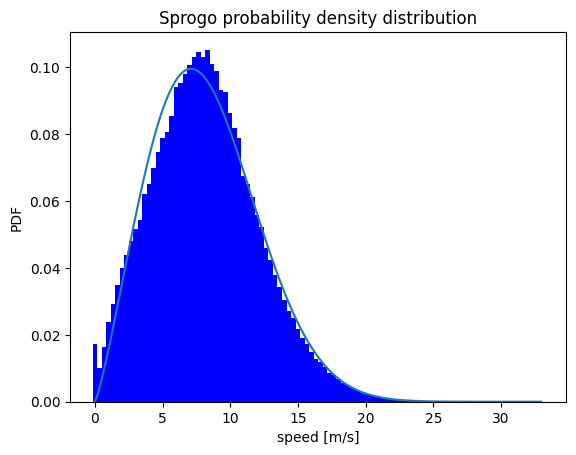

In [3]:
# DATA

data = pd.read_csv('sprog.tsv', delimiter='\t', header=None, 
                    names=['t','V','dir67', 'dir70'])

time_all = data['t'].values
V_all = data['V'].values
dir67_all = data['dir67'].values
dir70_all = data['dir70'].values

V_array = []
dir_array = []
time_array = []
for i in range(len(V_all)):
    if V_all[i] < 90:
        if dir67_all[i] < 900:
            V_array.append(V_all[i])
            dir_array.append(dir67_all[i])
            time_array.append(time_all[i])
        elif dir70_all[i] < 900:
            V_array.append(V_all[i])
            dir_array.append(dir70_all[i])
            time_array.append(time_all[i])

V_array = np.array(V_array)
dir_array = np.array(dir_array)
time_array = np.array(time_array)

Prated = 13*10**6
Urp = 12
Ucutoff = 25

compute_Weibull(V_array)



num=100

plot_histogram(array_data=V_array, num=num, color='b', label='Histrogram')
plt.title("Sprogo probability density distribution")
plt.xlabel("speed [m/s]")
plt.ylabel("PDF")
plt.show()


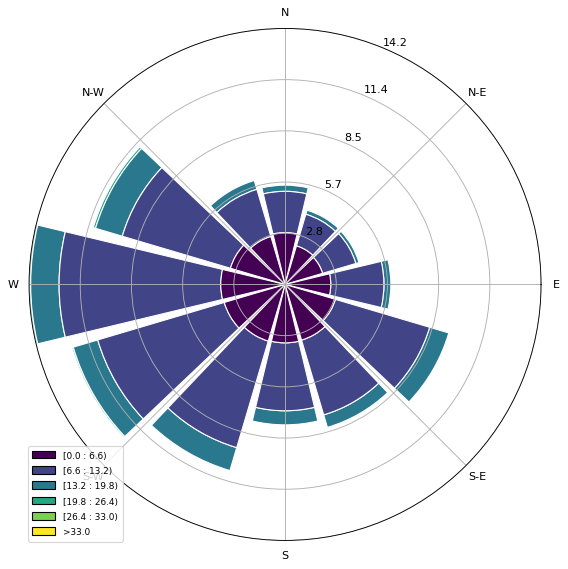

In [7]:
# WIND ROSE

ax = WindroseAxes.from_ax()
ax.bar(dir_array, V_array, normed=True, opening=0.9, edgecolor='white', nsector=12)
ax.set_legend()

for sector 0: k = 1.92 and A = 7.77
for sector 1: k = 1.88 and A = 7.59
for sector 2: k = 1.94 and A = 7.60
for sector 3: k = 2.15 and A = 8.36
for sector 4: k = 2.35 and A = 9.73
for sector 5: k = 2.20 and A = 8.90
for sector 6: k = 2.05 and A = 8.85
for sector 7: k = 2.36 and A = 9.80
for sector 8: k = 2.47 and A = 9.92
for sector 9: k = 2.66 and A = 10.06
for sector 10: k = 2.38 and A = 10.20
for sector 11: k = 1.98 and A = 8.45
AEP 1243223813911.8398


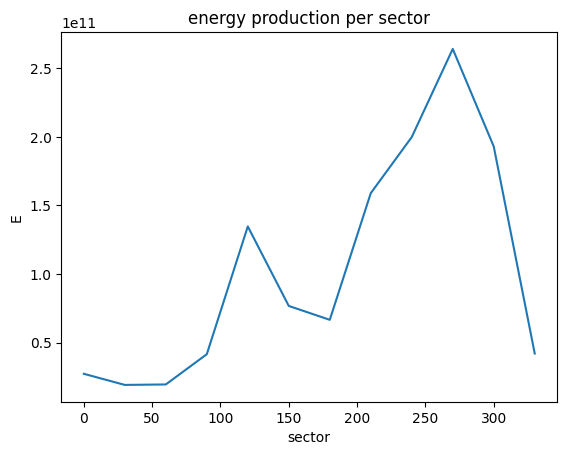

In [24]:
# COMPUTE AEP
# parameter k is constant but A is not => how does it change???


data_sector = divide_in_sector(velocity=V_array, direction=dir_array, time=time_array)

T = 24*365
E = []

for i in range(len(data_sector)):
    sector = data_sector[i]
    fi = len(sector)/len(V_array)

    k, A = compute_Weibull_parameters(sector)
    print(f'for sector {i}: k = {k:.2f} and A = {A:.2f}')

    integral1 = integrate_function(integrand1, 0, Urp,          k, A, Prated, Urp, Ucutoff)
    integral2 = integrate_function(integrand2, Urp, Ucutoff,    k, A, Prated, Urp, Ucutoff)

    Ei = T * fi * (integral1+integral2)
    E.append(Ei)

AEP = np.sum(E)
print('AEP', AEP)

direction = np.arange(0, 360, 30)

plt.plot(direction, E)
plt.title('energy production per sector')
plt.ylabel('E')
plt.xlabel('sector')
plt.show()


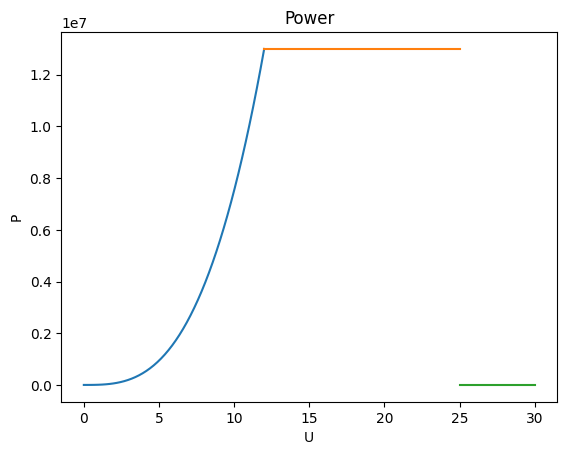

In [22]:
# just to show the power function

U1 = np.linspace(0,Urp)
P1 = Power1(U1, Prated, Urp)
U2 = np.linspace(Urp, Ucutoff)
P2 = np.full(len(U2), Prated)
U3 = np.linspace(Ucutoff, 30)
P3 = np.full(len(U3), 0)
plt.plot(U1, P1)
plt.plot(U2, P2)
plt.plot(U3, P3)

plt.title('Power')
plt.ylabel('P')
plt.xlabel('U')
plt.show()